# An Analysis of the Location Data of Hospitals in Metro Manila 

**This is a Capstone Project for the IBM Data Science Certificate. The data in this project is not exhaustive and therefore inaccurate, and is only used to demonstrate the skills learned from the IBM Data Science Course.**

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

When there is an oppurtunity to open a business,  the existing infrastructure affects the type of costumers present. In the Philippines, **government** hospitals are more affordable than **private** hospitals but are less accessible due to long lines and schedules. Proximity and specialty aside, *private hospitals cater to higher income patients by providing more comforts and amenities at a higher price*. 

Since the class (government or private) of the hospital affects the demographic, it would be worthwhile to learn how this affects the type of businesses and venues that exist at a walking distance from the hospital. Those visiting the hospital are also potential costumers for businesses that are a walking distance from the hospital. Using the foursquare API, data about the venues surrounding government and private hospitals can be compared to see if there is a meaningful difference. Finally, machine learning can be applied to predict whether a hospital is of the class government or private based on the businesses and venues that surround it.

The questions that we would like to answer in this project are:
* **What are the differences between the type of businesses/venues that surround government and private hospitals?**
* **Can we predict if a hospital is government or private based on the venues that surround it?**

## 2. Data <a name="data"></a>

The hospitals to be used in this project are those located in the **National Capital Region of the Philippines**, which contains the cities and municipalities compromising Metropolitan Manila. This is to ensure that there is enough data from foursquare about the different venues surrounding the hospitals. A [CSV file](https://nhfr.doh.gov.ph/rfacilities2list.php?export=csv) from the Philippine Department of Health website already contains the list of health facilities as well as the street address. Geopy will be used to get the specific latitude and longitude for each hospital street address.The foursquare API will then be used to gather information about the different venues surrounding each hospital.
  
The specific data gathered about the venues will be the category of the venue and its number. The idea is that Government Hospitals will attract a different set of businesses from Private Hospitals. The venues gathered will be set at 500 meters, which is the maximum comfortable walking distance from the hospital. The CSV file from the department of health also contains data about each hospital's bed capacity, which can also be used for an analysis on the effect of the size of the hospital on the businesses that surround it.

Importing Relevant Libraries

In [14]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library



Foursquare Credentials:

In [85]:
CLIENT_ID = '' # Foursquare ID removed for privacy
CLIENT_SECRET = '' # Foursquare Secret removed for privacy
VERSION = '20180604'
LIMIT = 100

Reading the CSV file and renaming the relevant information:

In [15]:
hospitals = pd.read_csv('rfacilities2.csv')
hospitals.head()

,"Date and Time Downloaded : 11/18/2020 04:27:18 pm""Health Facility Code""",Health Facility Code Short,Facility Name,Old Health Facility Names,Old Health Facility Name 2,Old Health Facility Name 3,Health Facility Type,Ownership Major Classification,Ownership Sub-Classification for Government facilities,Ownership Sub-Classification for private facilities,...,Email Address,Alternate Email Address,Official Website,Facility Head: Last Name,Facility Head: First Name,Facility Head: Middle Name,Facility Head: Position,Hospital Licensing Status,Service Capability,Bed Capacity
0,DOH000000000000013,13,MURPHY SUPER HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,...,,,,FLORENDO,BERNARDO,A.,Rural Health Physician,NaN,NaN,NaN
1,DOH000000000000021,21,BERNARDO HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,...,bernardohealthcenter@yahoo.com,,,BERNARDO,MARIA MELINDA,,Rural Health Physician,NaN,NaN,NaN
2,DOH000000000000022,22,SAUYO HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,...,sauyohealthcenter@yahoo.com.ph,,,ALLI,MARIA LEDA,C.,Rural Health Physician,NaN,NaN,NaN
3,DOH000000000000102,102,PAYATAS B HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,...,,,,DIZON,ELMIRA,S.,Rural Health Physician,NaN,NaN,NaN
4,DOH000000000000138,138,BAGONG SILANGAN HEALTH CENTER,BAGONG SILANG HEALTH CENTER,,,Rural Health Unit,Government,Local Government Unit,,...,,,,PAULINO,JOSELITO,R.,Rural Health Physician,NaN,NaN,NaN


In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [17]:
hospitals.rename(columns={hospitals.columns[2]: 'Name',hospitals.columns[6]: 'Type', hospitals.columns[7]: 'Class',hospitals.columns[10]: 'Street',hospitals.columns[16]: 'City',hospitals.columns[33]: 'Beds'}, inplace = True)

In [18]:
hospitals.head()

,"Date and Time Downloaded : 11/18/2020 04:27:18 pm""Health Facility Code""",Health Facility Code Short,Name,Old Health Facility Names,Old Health Facility Name 2,Old Health Facility Name 3,Type,Class,Ownership Sub-Classification for Government facilities,Ownership Sub-Classification for private facilities,Street,Building name and #,Region Name,Region PSGC,Province Name,Province PSGC,City,City/Municipality PSGC,Barangay Name,Barangay PSGC,Zip Code,Landline Number,Landline Number 2,Fax Number,Email Address,Alternate Email Address,Official Website,Facility Head: Last Name,Facility Head: First Name,Facility Head: Middle Name,Facility Head: Position,Hospital Licensing Status,Service Capability,Beds
0,DOH000000000000013,13,MURPHY SUPER HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,2ND FLOOR 18TH AVENUE,,NATIONAL CAPITAL REGION (NCR),130000000,"NCR, SECOND DISTRICT (Not a Province)",137400000,QUEZON CITY,137404000,SAN ROQUE,137404102,,,,,,,,FLORENDO,BERNARDO,A.,Rural Health Physician,NaN,NaN,NaN
1,DOH000000000000021,21,BERNARDO HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,ERMIN GARCIA STREET,,NATIONAL CAPITAL REGION (NCR),130000000,"NCR, SECOND DISTRICT (Not a Province)",137400000,QUEZON CITY,137404000,PINAGKAISAHAN,137404083,,,,,bernardohealthcenter@yahoo.com,,,BERNARDO,MARIA MELINDA,,Rural Health Physician,NaN,NaN,NaN
2,DOH000000000000022,22,SAUYO HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,GREENVILLE SUBDIVISION,,NATIONAL CAPITAL REGION (NCR),130000000,"NCR, SECOND DISTRICT (Not a Province)",137400000,QUEZON CITY,137404000,SAUYO,137404111,,+63 024532625,,,sauyohealthcenter@yahoo.com.ph,,,ALLI,MARIA LEDA,C.,Rural Health Physician,NaN,NaN,NaN
3,DOH000000000000102,102,PAYATAS B HEALTH CENTER,,,,Rural Health Unit,Government,Local Government Unit,,17 BULACAN STREET,,NATIONAL CAPITAL REGION (NCR),130000000,"NCR, SECOND DISTRICT (Not a Province)",137400000,QUEZON CITY,137404000,PAYATAS,137404138,,,,,,,,DIZON,ELMIRA,S.,Rural Health Physician,NaN,NaN,NaN
4,DOH000000000000138,138,BAGONG SILANGAN HEALTH CENTER,BAGONG SILANG HEALTH CENTER,,,Rural Health Unit,Government,Local Government Unit,,A. BONIFACIO STREET,,NATIONAL CAPITAL REGION (NCR),130000000,"NCR, SECOND DISTRICT (Not a Province)",137400000,QUEZON CITY,137404000,BAGONG SILANGAN,137404010,,,,,,,,PAULINO,JOSELITO,R.,Rural Health Physician,NaN,NaN,NaN


The **Class** dictates whether the facility is *Government* or *Private*. The **Type** of facilities that we are going to include in this project are *hospitals* and *infirmaries*. We will be needing the **Street** and **City** columns for accessing the latitude and longitude using geopy. We will also be needing the **Beds** column to conduct exploratory analysis using the bedspace capacity. The file contains data on the larger hospitals with their declared bedspace, so hospitals with no bedspace will be dropped. 

Taking the relevant data:

In [19]:
data = hospitals[['Name','Type','Class','Street','City','Beds']]

In [20]:
data = data[(data['Type']=='Hospital') | (data['Type']=='Infirmary')] ##only hospitals and infirmaries

In [21]:
data = data.dropna(subset = ['Beds'], axis = 0) ##droping rows with NaN

In [22]:
data.shape

(185, 6)

In [24]:
data = data.reset_index(drop = True)

In [25]:
data.head()

,Name,Type,Class,Street,City,Beds
0,ALABANG MEDICAL CENTER,Hospital,Private,ALABANG-ZAPOTE ROAD,CITY OF MUNTINLUPA,18.0
1,ASIAN HOSPITAL INC.,Hospital,Private,"2205 CIVIC DRIVE, FILINVEST CORPORATE CITY",CITY OF MUNTINLUPA,296.0
2,"BERMUDEZ POLYCLINIC HOSPITAL, INC",Hospital,Private,"391 MALARIA ROAD, ZONE 6 DISTRICT 1 TALA",CALOOCAN CITY,20.0
3,BERNARDINO GENERAL HOSPITAL II,Hospital,Private,"BLOCK 1, LOT 2, NORTH OLYMPUS SUBDIVISION, ZAB...",QUEZON CITY,35.0
4,CHINESE GENERAL HOSPITAL AND MEDICAL CENTER,Hospital,Private,286 BLUMENTRITT STREET,SANTA CRUZ,592.0


The **City** column needs to be cleaned:

In [26]:
pd.DataFrame(data.City.unique())

,0
0,CITY OF MUNTINLUPA
1,CALOOCAN CITY
2,QUEZON CITY
3,SANTA CRUZ
4,CITY OF LAS PI?AS
5,CITY OF MANILA
6,TAGUIG CITY
7,CITY OF MANDALUYONG
8,CITY OF PARA?AQUE
9,SAMPALOC


In [27]:
data = data.replace({'CITY OF MANDALUYONG': ' MANDALUYONG', 'CITY OF MAKATI': 'MAKATI','CITY OF PASIG': 'PASIG','CITY OF MUNTINLUPA':'MUNTINLUPA','TONDO I / II':'TONDO','CITY OF SAN JUAN':'SAN JUAN','CITY OF MANILA':'MANILA','CITY OF LAS PI?AS':'LAS PINAS','CITY OF VALENZUELA':'VALENZUELA', 'CITY OF MARIKINA':'MARIKINA','CITY OF PARA?AQUE':'PARANAQUE'})

Using **Street** and **City**, the latitude and longitude can be gathered using geopy. This will be added to the existing dataframe. 

In [28]:
#initializing variables to store location data
latitude = np.zeros(len(data))
longitude = np.zeros(len(data))

In [29]:
#getting location data for each hospital. If the street name does not work, the name of the facility is attempted.
for i in range(len(data)):
    try:
        address =  data.loc[i,'Street'] + ',' + data.loc[i,'City']+ ', Philippines'
        str(address)
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude[i] = location.latitude
        longitude[i]= location.longitude
    except:
        try:
            address =  data.loc[i,'Name'] + ',' +data.loc[i,'City']+ ', Philippines'
            str(address)
            geolocator = Nominatim(user_agent="foursquare_agent")
            location = geolocator.geocode(address)
            latitude[i] = location.latitude
            longitude[i]= location.longitude
        except:
            latitude[i] = np.NaN
            longitude[i]= np.NaN

In [30]:
data['Latitude']= latitude
data['Longitude']= longitude
data.dropna(axis = 0, inplace= True)  ##droping rows with no location data. this can be gathered manually one by one for a complete project
data.reset_index(drop = True, inplace = True)
print(data.shape)
data.head()

(136, 8)


,Name,Type,Class,Street,City,Beds,Latitude,Longitude
0,ALABANG MEDICAL CENTER,Hospital,Private,ALABANG-ZAPOTE ROAD,MUNTINLUPA,18.0,14.419099,121.043914
1,BERNARDINO GENERAL HOSPITAL II,Hospital,Private,"BLOCK 1, LOT 2, NORTH OLYMPUS SUBDIVISION, ZAB...",QUEZON CITY,35.0,14.700589,121.034970
2,CHINESE GENERAL HOSPITAL AND MEDICAL CENTER,Hospital,Private,286 BLUMENTRITT STREET,SANTA CRUZ,592.0,14.626311,120.987791
3,DE OCAMPO MEMORIAL MEDICAL CENTER,Hospital,Private,2921 NAGTAHAN STREET SANTA MESA,MANILA,20.0,14.599832,120.999627
4,DR. FE DEL MUNDO MEDICAL CENTER,Hospital,Private,11 BANAWE STREET,QUEZON CITY,107.0,14.620604,121.009230


**Visualizing** the data might provide some more insights. Folium can be used to make an interactive map using the location data.

In [31]:
#getting the location data of Metropolitan Manila 

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Metro Manila, Philippines')
latitude_NCR = location.latitude
longitude_NCR= location.longitude

In [32]:
map_NCR= folium.Map(location=[latitude_NCR, longitude_NCR], zoom_start=11)

# add markers to map
for lat, lng, name, beds in zip(data['Latitude'], data['Longitude'], data['Name'], data['Beds']):
    label = '{}, {}'.format(name, beds)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NCR)  
    
map_NCR

Some of the data is outside of Metro Manila, which might be from an error using geopy. This will be dropped along with some facilities which are irrelevant to the project.

In [33]:
#dropping prison hospitals, government mental health facilities, and 'JOSE R. REYES MEMORIAL MEDICAL CENTER' which is out of NCR
data = data.drop([14, 75,101])
data.reset_index(drop = True, inplace = True)
data.head()

,Name,Type,Class,Street,City,Beds,Latitude,Longitude
0,ALABANG MEDICAL CENTER,Hospital,Private,ALABANG-ZAPOTE ROAD,MUNTINLUPA,18.0,14.419099,121.043914
1,BERNARDINO GENERAL HOSPITAL II,Hospital,Private,"BLOCK 1, LOT 2, NORTH OLYMPUS SUBDIVISION, ZAB...",QUEZON CITY,35.0,14.700589,121.034970
2,CHINESE GENERAL HOSPITAL AND MEDICAL CENTER,Hospital,Private,286 BLUMENTRITT STREET,SANTA CRUZ,592.0,14.626311,120.987791
3,DE OCAMPO MEMORIAL MEDICAL CENTER,Hospital,Private,2921 NAGTAHAN STREET SANTA MESA,MANILA,20.0,14.599832,120.999627
4,DR. FE DEL MUNDO MEDICAL CENTER,Hospital,Private,11 BANAWE STREET,QUEZON CITY,107.0,14.620604,121.009230


In [36]:
print(data.shape)

(133, 8)


Different venues around each hospital can then be found using foursquare. The venues should be a *walking distance* from each hospital, so the raidus is set to **500 meters**. The function **getNearbyVenues** creates an API request for each row in the data, and returns the venue name, category, and location data for each hospital.

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:  
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results = [0]
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Hospital Latitude', 
                  'Hospital Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The data of all the venues for each hospital can now be gathered in a single dataframe:

In [37]:
venues = getNearbyVenues(names=data['Name'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

ALABANG MEDICAL CENTER
BERNARDINO GENERAL HOSPITAL II
CHINESE GENERAL HOSPITAL AND MEDICAL CENTER
DE OCAMPO MEMORIAL MEDICAL CENTER
DR. FE DEL MUNDO MEDICAL CENTER
DR. JESUS C. DELGADO MEMORIAL HOSPITAL
DR. JOSE FABELLA MEMORIAL HOSPITAL
DR. JOSE N. RODRIGUEZ MEMORIAL HOSPITAL
DR. VICTOR R. POTENCIANO MEDICAL CENTER
D.T. PROTACIO HOSPITAL
EAST AVENUE MEDICAL CENTER
GEN. MIGUEL MALVAR MEDICAL RESEARCH FOUNDATION, INC.
HOSPITAL OF THE INFANT JESUS MEDICAL CENTER
JESUS IMMACULATE CONCEPCION HOSPITAL
LADY OF LOURDES HOSPITAL OF CAYBIGA, INC.
LAS PIÑAS GENERAL HOSPITAL AND SATELLITE TRAUMA CENTER
MAKATI MEDICAL CENTER
MARIKINA VALLEY MEDICAL CENTER
MARY CHILES GENERAL HOSPITAL, INC.
MCPC ST THERESE OF LISIEUX DOCTORS HOSPITAL
MEDICAL CENTER MANILA INC.
MEDICAL CENTER PARAÑAQUE, INC.
UHBI-PARAÑAQUE DOCTORS HOSPITAL, INC.
PASAY CITY GENERAL HOSPITAL
PASIG CITY GENERAL HOSPITAL
PERPETUAL SUCCOR HOSPITAL AND MATERNITY INC.
PHILIPPINE CHILDREN'S MEDICAL CENTER
PHILIPPINE HEART CENTER
RIZAL MEDIC

In [43]:
venues.head()

,Name,Hospital Latitude,Hospital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALABANG MEDICAL CENTER,14.419099,121.043914,The Landmark Supermarket,14.416988,121.042268,Supermarket
1,ALABANG MEDICAL CENTER,14.419099,121.043914,Tom's World,14.417812,121.041609,Arcade
2,ALABANG MEDICAL CENTER,14.419099,121.043914,Cafe Mary Grace,14.417428,121.042263,Café
3,ALABANG MEDICAL CENTER,14.419099,121.043914,Crimson Hotel,14.420068,121.042365,Hotel
4,ALABANG MEDICAL CENTER,14.419099,121.043914,Decathlon Philippines,14.418870,121.040649,Sporting Goods Shop


Looking at the total venues for each hospital using groupby:

In [42]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))
venues.groupby('Name').count()

There are 234 uniques categories.


,Hospital Latitude,Hospital Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Name,,,,,,
ADVENTIST MEDICAL CENTER MANILA,16,16,16,16,16,16
AIR FORCE GENERAL HOSPITAL,33,33,33,33,33,33
ALABANG MEDICAL CENTER,62,62,62,62,62,62
ALABANG MEDICAL CLINIC,47,47,47,47,47,47
ALABANG MEDICAL CLINIC - MUNTINLUPA BRANCH,13,13,13,13,13,13
ALFONSO SPECIALIST HOSPITAL,11,11,11,11,11,11
"ALLIED CARE EXPERTS (ACE) MEDICAL CENTER - PATEROS, INC.",27,27,27,27,27,27
"ALLIED CARE EXPERTS (ACE) MEDICAL CENTER - QUEZON CITY, INC.",20,20,20,20,20,20
AMANG RODRIGUEZ MEMORIAL MEDICAL CENTER,16,16,16,16,16,16


## 3. Methodology <a name="methodology"></a>

Previously, the data for the venues that are a walking distance from each hospital were gathered. The next step would be to perform some exploratory data analysis. The question we want to answer in this step is:   
  
* **What are the differences between the type of businesses/venues that surround government and private hospitals?**

In this step, the pearson correlation factor will be used to see if the size of the hospital (dictated by its bed capacity) affects the type and number of venues. An analysis of variance will also be used to see if the type of venues for government and private are statistically different. 

The final step includes machine learning classification systems. The question we want to answer in this step is:   
  
* **Can we predict if a hospital is government or private based on the venues that surround it?**

Here, data would be split into training sets and testing sets in order to verify the out-of-sample accuracy. The classifier algorithms used will be k nearest neighbors, decision tree, support vector machine and logistic regression. Each classifier algorithm will be optimized by choosing the best parameter (e.g. the best 'k' in K nearest neighbors). It would be interesting to find out how each algorithm performs.  


## 4. Analysis <a name="analysis"></a>

First, the effect of the size of the hospital on the surrounding venues needs to be taken into account. For example, a larger hospital might cause a greater number of restaurants and pharmacies than a smaller hospital. These two venue categories where chosen because they are the most relavant to the data, and to reduce the number of API calls.  
  
The **Beds** column in the data is the overall total bed capacity of the hospital. The functions **pharmacy_counts** and **food_counts** return the number of pharmacies and restaurants within a walking distance of 500 meters. If the effect of the hospital bed capacity is significant, it will be added to the succeeding analyses.

In [86]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['Categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [87]:
#returns the number of venues with category "pharmacy" or "drugstore" within walking distance (500 meters)

def pharmacy_counts(latitudes, longitudes, radius=500):
    len_list=[]
    search_query = 'pharmacy'
    for lat, lng in zip(latitudes, longitudes):
        try:
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            results = requests.get(url).json()
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            filtered_columns = ['categories']
            dataframe_filtered = dataframe.loc[:, filtered_columns]
            dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)
            len_list.append(len(dataframe_filtered[(dataframe_filtered['categories'].str.lower() == 'pharmacy') | (dataframe_filtered['categories'].str.lower() == 'drugstore')]))
        except:
            len_list.append(0)

               
            
    return(len_list)

In [88]:
#returns the number of venues associated with food like fastfood restaurants, cafes, etc. within walking distance (500 meters)

def food_counts(latitudes, longitudes, radius=500):
    len_list=[]
    search_query = 'food'
    for lat, lng in zip(latitudes, longitudes):
        try:
            url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            results = requests.get(url).json()
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            len_list.append(len(dataframe))
        except:
            len_list.append(0)

               
            
    return(len_list)

Getting the pharmacies and restaurants within walking distance from each hospital in the data:

In [107]:
data_pharma_counts =  pharmacy_counts(latitudes=data['Latitude'], longitudes=data['Longitude'])
data_restaurant_counts =  food_counts(latitudes=data['Latitude'], longitudes=data['Longitude'])

In [102]:
#data was saved since foursquare had some errors due to the API calls
# pharma_counts =pd.read_csv('pharma.csv')
# restaurant_counts =pd.read_csv('food.csv')
# data_pharma_counts = pharma_counts['Pharamacy Count']
# data_restaurant_counts = restaurant_counts['Restaurant Count']

In [48]:
#importing libraries for metrics and visualization 
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt

### Beds vs Pharmacies

The Pearson Correlation Coefficient measures linear correlation between two sets of data. A value closer to +1 indicates a positive linear correlation and a value closer to −1 indicates negative linear correlation. A value near zero indicates zero correlation.

In [103]:
corr, p = stats.pearsonr(data['Beds'],data_pharma_counts)
print('Correlation Coefficient is', corr)
print('P-value is', corr)

Correlation Coefficient is 0.2741700569034865
P-value is 0.2741700569034865


The correlation coefficient is close to zero which implies that **there is no linear correlation between the bed capacity of the hospital and the number of pharmacies**. This can be seen in the figure below, which is not linear. The P-value however is greater than 0.1 which indicates that there is no certainty in the data.

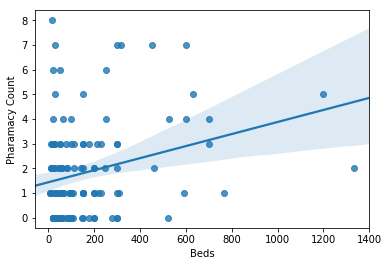

In [104]:
#scatter plot of bed capacity vs number of pharmacies
sns.regplot(x = data['Beds'], y = data_pharma_counts)

### Beds vs Restaurants

The Pearson Correlation Coefficient measures linear correlation between two sets of data. A value closer to +1 indicates a positive linear correlation and a value closer to −1 indicates negative linear correlation. A value near zero indicates zero correlation.

In [105]:
corr, p = stats.pearsonr(data['Beds'],data_restaurant_counts)
print('Correlation Coefficient is', corr)
print('P-value is', corr)

Correlation Coefficient is 0.2850344176504797
P-value is 0.2850344176504797


The correlation coefficient is close to zero which implies that **there is no linear correlation between the bed capacity of the hospital and the number of restaurants**. This can be seen in the figure below, which is not linear. The P-value however is greater than 0.1 which indicates that there is no certainty in the data.

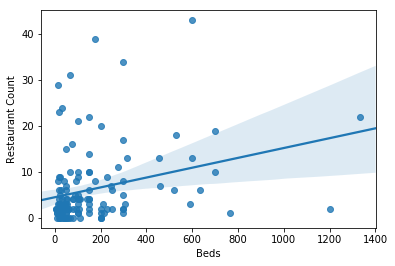

In [106]:
#scatter plot of bed capacity vs number of pharmacies
sns.regplot(x = data['Beds'], y = data_restaurant_counts)

Since it looks like the bedspace capacity has no linear correlation on the number of venues, it will not be included as a feature in the succeeding analyses. **There are a lot more factors that affect the number and type of venues around the hospital. In fact, the hospital might not be a factor at all, but this was just done in order to perform exploratory analysis and to see if it is a viable feature to add in the next step.** It could also just be that there is just not enough data (high P-value).

### Analysis of Variance

In this step, an analysis of variance (ANOVA) will be performed on the data to compare the means of the Goverment and Private hospitals. But first, the venues have to be prepared using one-hot encoding:


In [109]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Name'] = venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Name,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Cafeteria,Café,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Basketball Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Costume Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Internet Cafe,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Playground,Plaza,Police Station,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Toll Plaza,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,ALABANG MEDICAL CENTER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ALABANG MEDICAL CENTER,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Grouping by hospital and getting the total for each venue category:

In [223]:
grouped = onehot.groupby('Name').sum().reset_index() #taking the sum of each type of venue per hospital
grouped.head()

,Name,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Cafeteria,Café,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Basketball Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Costume Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Internet Cafe,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Playground,Plaza,Police Station,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Toll Plaza,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,ADVENTIST MEDICAL CENTER MANILA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,AIR FORCE GENERAL HOSPITAL,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

The **Class** column can then be added from the data, and subsequent grouping can be done by class:

In [191]:
grouped_anova = grouped
grouped_anova = grouped_anova.drop(columns = 'Name') 
grouped_anova['Class'] = data['Class']
private = grouped_anova[grouped_anova['Class']=='Private'] #dataset for private hospitals
private = private.drop(columns = 'Class')
government = grouped_anova[grouped_anova['Class']=='Government'] #dataset for government hospitals
government = government.drop(columns = 'Class')

Anova can then be performed using f_oneway from scipy.stats:

In [123]:
import scipy.stats as stats

In [220]:
stat, p_value = stats.stats.f_oneway(private,government)
p_value = pd.DataFrame(data = p_value, index = private.columns)
p_value[p_value[0] < 0.05]

,0
Chocolate Shop,0.036153
Food Court,0.003575
Fountain,0.036153
Indian Restaurant,0.036153
Museum,0.047205
Optical Shop,0.009674
Scenic Lookout,0.036153


A P-value with less than 0.05 suggests that the class (government/private) of the hospital affects the number of the specific venue category.  It seems like the class of the hospital affects the number of chocolate shops, food courts, fountains, indian restaurants, museums, optical shops, and scenic lookouts. The lowest P-value is that of *Food Courts* with 0.003575. Correlation does not equal causation, and all of these values can just be happenstance. There is not much to learn here, except that there is moderate certainty that there are less food courts in private hospitals than in government hospitals.

In [230]:
print('Mean number of food courts in Private hospitals:',private['Food Court'].mean(axis = 0))
print('Mean number of food courts in Government hospitals:',government['Food Court'].mean(axis = 0))

Mean number of food courts in Private hospitals: 0.054945054945054944
Mean number of food courts in Government hospitals: 0.23809523809523808


### Classification

In this section, machine learning algorithms are used to see if they can predict the class of the hospitals are used based on the venues that exist around it. First, the features set must be separated from the category set:

In [238]:
# 'grouped' is the venues data which was arranged using one-hot encoding
X = grouped.drop('Name',axis = 1)
X[0:5]

,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Cafeteria,Café,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Basketball Court,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Costume Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Government Building,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Internet Cafe,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lounge,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Playground,Plaza,Police Station,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shawarma Place,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Toll Plaza,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,1,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [248]:
merged = pd.merge(grouped, data) #implicitly joining by Name, just in case resetting index affected data
y = merged['Class']

Next, the data is split into training and testing sets to check the out-of-sample accuracy. The classification models will be fitted using the training data, and the accuracy will be tested using the testing data.

In [249]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)

Next, the data is normalized so that outliers wont affect the data and different scales for each feature will be addressed. This step is optional because the data are all in the same units (number of each venue category present), but it is good practice to normalize.

In [234]:
from sklearn import preprocessing

In [254]:
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_whole= preprocessing.StandardScaler().fit(X_train).transform(X)

C:\Users\pc user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### K Nearest Neighbors


KNN is an algorithm that uses K closest values for prediction. In order to have the best accuracy, different values for K are tried. The K with the best out-of-sample accuracy 

In [241]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [256]:
# Performing KNN with K =  1 to 50
Klist = list(range(1,51))
K_acc = np.zeros(len(Klist))
for i,n in enumerate(Klist):
    k = n
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    K_acc[i]= metrics.accuracy_score(y_test, yhat) #testing for out-of-sample accuracy

Visualizing the accuracy can provide some more insight rather than just taking the the highest value.

The best accuracy was 0.7407407407407407 with k= 11


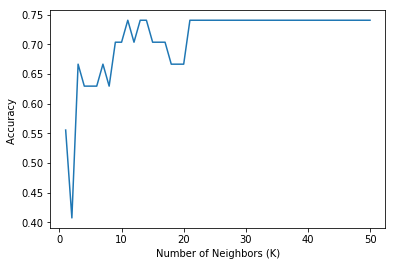

In [265]:
sns.lineplot( x = Klist, y = K_acc)
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
print( "The best accuracy was", K_acc.max(), "with k=", K_acc.argmax()+1) 

In [258]:
neigh = KNeighborsClassifier(n_neighbors = K_acc.argmax()+1).fit(X_train,y_train)
yhat_KNN = neigh.predict(X_test)

The best accuracy was 0.7407407407407407 with k= 11


The highest accuracy was 0.74 at k = 11 and the same for K values of 22 and onwards. Inspecting the plot, the accuracy elbows at around K = 22. This is usually a better K to use. Testing the accuracy with k = 22 and using the whole data set results with an accuracy of 0.78. However the recall (True positive rate) for Government hospitals is very low at 0.14.

In [259]:
#test_neigh = KNeighborsClassifier(n_neighbors = K_acc.argmax()+1).fit(X_whole,y) the highest K is at 11, but the accuracy elbows at around 22
test_neigh = KNeighborsClassifier(n_neighbors = 22).fit(X_whole,y) #X_whole is the combined data of X_test and X_train
yhat_KNN_test = test_neigh.predict(X_test)
data_accuracy = metrics.accuracy_score(y_test, yhat_KNN_test)
data_accuracy

0.7777777777777778

In [298]:
cnf_matrix = confusion_matrix(y_test, yhat_KNN_test)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_KNN))

              precision    recall  f1-score   support

  Government       0.50      0.14      0.22         7
     Private       0.76      0.95      0.84        20

   micro avg       0.74      0.74      0.74        27
   macro avg       0.63      0.55      0.53        27
weighted avg       0.69      0.74      0.68        27



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

### Decision Tree

Decision trees classify labels by learning simple decision rules inferred from the data features. The deeper the tree, the more complex the decision rules and the fitter the model. 

In [261]:
from sklearn.tree import DecisionTreeClassifier

In [262]:
Depth_list = list(range(1,21))
Depth_acc = np.zeros(len(Depth_list))
for i,n in enumerate(Depth_list):
    tree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    tree.fit(X_train,y_train)
    yhat=tree.predict(X_test)
    Depth_acc[i]=metrics.accuracy_score(y_test,yhat)

Visualaizing the accuracy can show the best depth:

The best accuracy is 0.6296296296296297 with depth= 1


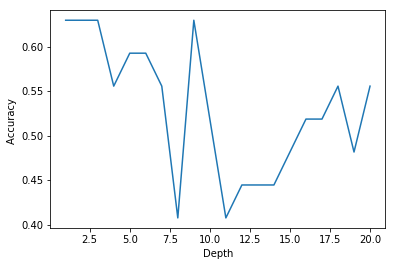

In [267]:
sns.lineplot( x = Depth_list, y = Depth_acc)
plt.ylabel('Accuracy ')
plt.xlabel('Depth')
print( "The best accuracy is", Depth_acc.max(), "with depth=", Depth_acc.argmax()+1) 

The highest depth accuracy was at depth = 1 and depth = 9. The depth will be set to 9 since a depth of 1 might be too simplistic and be overfitting by underfitting. Using the whole X data set, the accuracy is around 0.78. 

In [270]:
## using depth = 9
Loantree = DecisionTreeClassifier(criterion="entropy", max_depth = 9)
Loantree.fit(X_whole,y) #X_whole is the combined data of X_test and X_train
yhat_tree=Loantree.predict(X_test) 
metrics.accuracy_score(y_test,yhat_tree)

0.7777777777777778

In [299]:
cnf_matrix = confusion_matrix(y_test, yhat_tree)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tree))

              precision    recall  f1-score   support

  Government       0.56      0.71      0.63         7
     Private       0.89      0.80      0.84        20

   micro avg       0.78      0.78      0.78        27
   macro avg       0.72      0.76      0.73        27
weighted avg       0.80      0.78      0.79        27



### Support Vector Machine

SVM performs classification by finding the hyperplane that separates the data. Mapping data into a higher order space can be done using different kernelling models. In this step, different models are tried and the model with the highest accuracy is chosen.

In [271]:
from sklearn import svm

In [272]:
models = ['linear', 'poly','rbf','sigmoid']
models_acc = np.zeros(len(models))
for i,n in enumerate(models):
    svm_model=svm.SVC(kernel=n)
    svm_model.fit(X_train,y_train)
    yhat = svm_model.predict(X_test)
    models_acc[i]= metrics.accuracy_score(y_test, yhat)


C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Visualizing the accuracy for each model:

The best accuracy was  0.7407407407407407 with model = poly


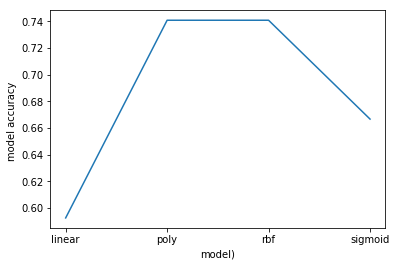

In [273]:
sns.lineplot( x = models, y = models_acc)
plt.ylabel('model accuracy ')
plt.xlabel('model)')
print( "The best accuracy was ", models_acc.max(), "with model =", models[models_acc.argmax()]) 

The best kernelling models are 'poly' and 'rbf'. Applying both to the whole X data set, they both have an accuracy of about 0.74.

In [301]:
svm_model=svm.SVC(kernel='rbf')
svm_model.fit(X_whole,y)
yhat_svm = svm_model.predict(X_test)
metrics.accuracy_score(y_test,yhat_svm)

C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7407407407407407

In [276]:
svm_model=svm.SVC(kernel='poly')
svm_model.fit(X_whole,y)
yhat_svm = svm_model.predict(X_test)
metrics.accuracy_score(y_test,yhat_svm)

C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7407407407407407

### Logistic Regression

Logistic regression classification uses a logistic function to model a binary dependent variable. It can use different algorithms to solve the optimization problem.

In [277]:
from sklearn.linear_model import LogisticRegression

In [282]:
solver = ['newton-cg','liblinear', 'lbfgs', 'sag', 'saga' ]
solver_acc = np.zeros(len(solver))
for i,n in enumerate(solver):
    lr =LogisticRegression(C=0.01,solver= n).fit(X_train,y_train)
    yhat = lr.predict(X_test)
    solver_acc[i]= metrics.accuracy_score(y_test, yhat)


C:\Users\pc user\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The best accuracy was  0.7037037037037037 with solver = newton-cg


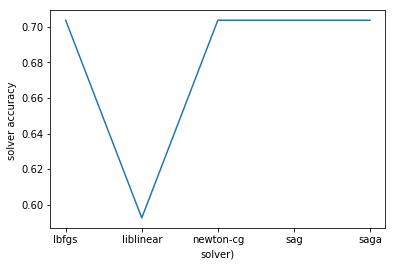

In [283]:
sns.lineplot( x = solver, y = solver_acc)
plt.ylabel('solver accuracy ')
plt.xlabel('solver)')
print( "The best accuracy was ", solver_acc.max(), "with solver =", solver[solver_acc.argmax()]) 

The best solver was 'newton-cg' with an accuracy of 0.704. The solution did not converge for the 'sag' and 'saga' solvers. Using 'newton-cg' on the whole X dataset to train the model, the accuracy on the test data set was around 0.74. However, the log-loss value (lower is better) was only at 0.5.

In [284]:
lr =LogisticRegression(C=0.01,solver='newton-cg').fit(X_whole,y)
yhat_lr= lr.predict(X_test)
metrics.accuracy_score(y_test,yhat_lr)

0.7407407407407407

In [285]:
yhat_lr_prob = lr.predict_proba(X_test)
from sklearn.metrics import log_loss
log_loss(y_test,yhat_lr_prob)

0.5081078660013639

## 5. Results and Discussion <a name="results"></a>

For the exploratory analysis, it looked like the bedspace capacity has no linear correlation on the number of businesses surrounding the hospital. Atlhough it is logical to think that there should be more venues for a larger hospital, there are a number of reasons of why this might be:
  
* The number of patients visiting the hospital is not proportional to the bed capacity. Outpatient services that do not require beds can be a factor.  
* The location demographics can affect the type of businesses present. For example, a highly urban city like Makati can have a high traffic of potential costumers, not necessarily from patients. A hospital located in a major highway or near a large shopping mall will also have higher number of venues surrounding it, regardless of its bed capacity. In this case, the hospital isnt even a factor at all.
* There simply isnt enough data to test the hypothesis, either from the number of venues or the number of hospitals. With a large enough data set, a higher certainty can be achieved. 
  
Ironically, this made the subsequent analyses easier, since the venues data no longer had to be scaled down based on the hospital capacity.

The same problems are true for the analysis of variance. Between government hospitals and private hospitals, the only difference with the a moderate certainty was the number of food courts. It can be assumed that since government hospitals cater more towards lower costs, they have more food courts than private hospitals which would be more inclined towards having restaurants.

For the machine learning classification systems, all the models performed well. Each model had a test accuracy of about 70%, with K nearest neighbors having the best test accuracy at around 0.74. Training using the whole data set, the accuracy increased to 0.78. However, even after training the model using the whole data, the recall (True Positive Rate) for government hospitals was only 0.14. The Decision Tree had the lowest test accuracy at only 0.63, but after training using the whole data set, the accuracy reached 0.78 and did not suffer low recall like KNN. 

## 6. Conclusion <a name="conclusion"></a>

Answering the first questions laid out for the project, **the only discernable difference between the type of businesses/venues that surround government and private hospitals** was the number of food court venues. The size of the hospital was not a factor in the number of venues that surround it. This shows how actual data can be different from the expected results, and the importance of exploratory analysis.   
  
Answering the second question, **predicting if a hospital is government or private based on the venues that surround it is possble**. The best model from those used was the Decision Trees Classifier, although each model performed relatively well. The converse implication of this can be of use to a stakeholder when opening a business near a hospital, in that certain types of businesses are more likely to be present (if not more successful) depending if the hospital is public or private.